Import Library

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import joblib
import math
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
from sklearn.metrics import confusion_matrix


Load Dataset

In [2]:
#membaca file excel
data = pd.read_excel('Dataset.xlsx')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')] #menghapus kolom 'Unnamed'

#mengubah dataset ke dalam bentuk dataframe
data = pd.DataFrame(data[['username', 'rating', 'comment']])
pd.set_option('display.max_colwidth', None)
data

,username,rating,comment
0,melan24,5,Mantap...kualitas tdk di ragukan lagi
1,oktavia2390,3,Pesenan warna hijau mbak kenapa datang warna burgundy
2,twilight1214,5,"Sangat bagus, paas di badan"
3,ratna_merkorios0809,5,Kenyamanan: baik\nStyling: casual\nSepadan dengan Harga: bagus\nBarangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi. Kurirnya ramah dan langganan trs aku dr dulu di toko ini
4,8eaxeyi8_9,1,"Brng tidak sesuai😡😡,tidak sesuai pesanan"
...,...,...,...
2995,\narlyasafitri,3,"Tampilan: bagus\nBagus walau bahan nya agak kaku, tapi sesuai sama harga bagus pkok nya"
2996,s*****j,5,"Bagus banget, cocok untuk di pakai di rumah2. Ga panas, dan bahannya lemes. Enak dipakai, cuman di bagian dadanya aku agak sempit"
2997,suzan991,3,Warna: 1 kali cuci luntur berubah warna kain kaku macam terpal
2998,nurjeni14,3,"Tampilan: bagus tapi sayang nyaa kebesaran, kepanjangan😭+bahan nya kaku tpi klo masalah bahan oke lah gapapa, tpi kebesaran, kepanjangan nya itu loh 😢kirain mah bisa juga untuk anak umur 11 th ternyta ga bisa. tpii gapapa terimakasihh untuk penjual nya."


Mapping Label Sentimen ke Representasi Angka

In [3]:
# Menentukan label sentimen berdasarkan rating
def label_sentimen(rating):
    if rating in [1, 2]:
        return -1  # sentimen negatif
    elif rating == 3:
        return 0   # sentimen netral
    else:
        return 1   # sentimen positif
    
# Mengganti nilai kolom 'rating' dengan label sentimen
data['rating'] = data['rating'].apply(label_sentimen)
data = data.rename(columns={'rating': 'Label Sentimen'})
data

,username,Label Sentimen,comment
0,melan24,1,Mantap...kualitas tdk di ragukan lagi
1,oktavia2390,0,Pesenan warna hijau mbak kenapa datang warna burgundy
2,twilight1214,1,"Sangat bagus, paas di badan"
3,ratna_merkorios0809,1,Kenyamanan: baik\nStyling: casual\nSepadan dengan Harga: bagus\nBarangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi. Kurirnya ramah dan langganan trs aku dr dulu di toko ini
4,8eaxeyi8_9,-1,"Brng tidak sesuai😡😡,tidak sesuai pesanan"
...,...,...,...
2995,\narlyasafitri,0,"Tampilan: bagus\nBagus walau bahan nya agak kaku, tapi sesuai sama harga bagus pkok nya"
2996,s*****j,1,"Bagus banget, cocok untuk di pakai di rumah2. Ga panas, dan bahannya lemes. Enak dipakai, cuman di bagian dadanya aku agak sempit"
2997,suzan991,0,Warna: 1 kali cuci luntur berubah warna kain kaku macam terpal
2998,nurjeni14,0,"Tampilan: bagus tapi sayang nyaa kebesaran, kepanjangan😭+bahan nya kaku tpi klo masalah bahan oke lah gapapa, tpi kebesaran, kepanjangan nya itu loh 😢kirain mah bisa juga untuk anak umur 11 th ternyta ga bisa. tpii gapapa terimakasihh untuk penjual nya."


Case Folding & Cleaning Data

In [4]:
def remove(sentence):
    #mengganti angka dengan spasi
    sentence = re.sub(r'[0-9]', ' ', sentence)
    #mengganti karakter non-alfanumerik dan non-spasi dengan spasi
    sentence = re.sub(r'[^\w\s]', ' ', sentence)
    #mengganti karakter yang bukan huruf dengan spasi
    sentence = re.sub(r'[^A-Za-z\s]', '', sentence)
    #mengubah data menjadi huruf kecil
    sentence = sentence.lower()
    #menghapus spasi/whitespace
    sentence = sentence.strip()
    #mengganti spasi berlebih dengan 1 spasi
    sentence = re.sub(r'\s+', ' ', sentence)
    #mengganti newline dengan spasi
    sentence = sentence.replace('\n', '')
    #mengganti underscore dengan spasi
    sentence = sentence.replace('_', '')
 
    return sentence

#menerapkan fungsi remove dari kolom komentar dan membuat kolom cleaning
data['cleaning'] = data['comment'].apply(lambda x: remove(x))
data

,username,Label Sentimen,comment,cleaning
0,melan24,1,Mantap...kualitas tdk di ragukan lagi,mantap kualitas tdk di ragukan lagi
1,oktavia2390,0,Pesenan warna hijau mbak kenapa datang warna burgundy,pesenan warna hijau mbak kenapa datang warna burgundy
2,twilight1214,1,"Sangat bagus, paas di badan",sangat bagus paas di badan
3,ratna_merkorios0809,1,Kenyamanan: baik\nStyling: casual\nSepadan dengan Harga: bagus\nBarangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi. Kurirnya ramah dan langganan trs aku dr dulu di toko ini,kenyamanan baik styling casual sepadan dengan harga bagus barangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi kurirnya ramah dan langganan trs aku dr dulu di toko ini
4,8eaxeyi8_9,-1,"Brng tidak sesuai😡😡,tidak sesuai pesanan",brng tidak sesuai tidak sesuai pesanan
...,...,...,...,...
2995,\narlyasafitri,0,"Tampilan: bagus\nBagus walau bahan nya agak kaku, tapi sesuai sama harga bagus pkok nya",tampilan bagus bagus walau bahan nya agak kaku tapi sesuai sama harga bagus pkok nya
2996,s*****j,1,"Bagus banget, cocok untuk di pakai di rumah2. Ga panas, dan bahannya lemes. Enak dipakai, cuman di bagian dadanya aku agak sempit",bagus banget cocok untuk di pakai di rumah ga panas dan bahannya lemes enak dipakai cuman di bagian dadanya aku agak sempit
2997,suzan991,0,Warna: 1 kali cuci luntur berubah warna kain kaku macam terpal,warna kali cuci luntur berubah warna kain kaku macam terpal
2998,nurjeni14,0,"Tampilan: bagus tapi sayang nyaa kebesaran, kepanjangan😭+bahan nya kaku tpi klo masalah bahan oke lah gapapa, tpi kebesaran, kepanjangan nya itu loh 😢kirain mah bisa juga untuk anak umur 11 th ternyta ga bisa. tpii gapapa terimakasihh untuk penjual nya.",tampilan bagus tapi sayang nyaa kebesaran kepanjangan bahan nya kaku tpi klo masalah bahan oke lah gapapa tpi kebesaran kepanjangan nya itu loh kirain mah bisa juga untuk anak umur th ternyta ga bisa tpii gapapa terimakasihh untuk penjual nya


Tokenization

In [5]:
#membuat fungsi tokenisasi menggunakan split
def tokenize(sentence):
    return sentence.split()

#menerapkan fungsi tokenize dari kolom cleaning dan membuat kolom tokenisasi
data['tokenisasi'] = data['cleaning'].apply(lambda x: tokenize(x))
data

,username,Label Sentimen,comment,cleaning,tokenisasi
0,melan24,1,Mantap...kualitas tdk di ragukan lagi,mantap kualitas tdk di ragukan lagi,"[mantap, kualitas, tdk, di, ragukan, lagi]"
1,oktavia2390,0,Pesenan warna hijau mbak kenapa datang warna burgundy,pesenan warna hijau mbak kenapa datang warna burgundy,"[pesenan, warna, hijau, mbak, kenapa, datang, warna, burgundy]"
2,twilight1214,1,"Sangat bagus, paas di badan",sangat bagus paas di badan,"[sangat, bagus, paas, di, badan]"
3,ratna_merkorios0809,1,Kenyamanan: baik\nStyling: casual\nSepadan dengan Harga: bagus\nBarangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi. Kurirnya ramah dan langganan trs aku dr dulu di toko ini,kenyamanan baik styling casual sepadan dengan harga bagus barangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi kurirnya ramah dan langganan trs aku dr dulu di toko ini,"[kenyamanan, baik, styling, casual, sepadan, dengan, harga, bagus, barangnya, bagus, banget, sesuai, pesanan, dan, real, gambar, pengiriman, cepat, packkingan, rapi, kurirnya, ramah, dan, langganan, trs, aku, dr, dulu, di, toko, ini]"
4,8eaxeyi8_9,-1,"Brng tidak sesuai😡😡,tidak sesuai pesanan",brng tidak sesuai tidak sesuai pesanan,"[brng, tidak, sesuai, tidak, sesuai, pesanan]"
...,...,...,...,...,...
2995,\narlyasafitri,0,"Tampilan: bagus\nBagus walau bahan nya agak kaku, tapi sesuai sama harga bagus pkok nya",tampilan bagus bagus walau bahan nya agak kaku tapi sesuai sama harga bagus pkok nya,"[tampilan, bagus, bagus, walau, bahan, nya, agak, kaku, tapi, sesuai, sama, harga, bagus, pkok, nya]"
2996,s*****j,1,"Bagus banget, cocok untuk di pakai di rumah2. Ga panas, dan bahannya lemes. Enak dipakai, cuman di bagian dadanya aku agak sempit",bagus banget cocok untuk di pakai di rumah ga panas dan bahannya lemes enak dipakai cuman di bagian dadanya aku agak sempit,"[bagus, banget, cocok, untuk, di, pakai, di, rumah, ga, panas, dan, bahannya, lemes, enak, dipakai, cuman, di, bagian, dadanya, aku, agak, sempit]"
2997,suzan991,0,Warna: 1 kali cuci luntur berubah warna kain kaku macam terpal,warna kali cuci luntur berubah warna kain kaku macam terpal,"[warna, kali, cuci, luntur, berubah, warna, kain, kaku, macam, terpal]"
2998,nurjeni14,0,"Tampilan: bagus tapi sayang nyaa kebesaran, kepanjangan😭+bahan nya kaku tpi klo masalah bahan oke lah gapapa, tpi kebesaran, kepanjangan nya itu loh 😢kirain mah bisa juga untuk anak umur 11 th ternyta ga bisa. tpii gapapa terimakasihh untuk penjual nya.",tampilan bagus tapi sayang nyaa kebesaran kepanjangan bahan nya kaku tpi klo masalah bahan oke lah gapapa tpi kebesaran kepanjangan nya itu loh kirain mah bisa juga untuk anak umur th ternyta ga bisa tpii gapapa terimakasihh untuk penjual nya,"[tampilan, bagus, tapi, sayang, nyaa, kebesaran, kepanjangan, bahan, nya, kaku, tpi, klo, masalah, bahan, oke, lah, gapapa, tpi, kebesaran, kepanjangan, nya, itu, loh, kirain, mah, bisa, juga, untuk, anak, umur, th, ternyta, ga, bisa, tpii, gapapa, terimakasihh, untuk, penjual, nya]"


Normalization

In [6]:
import importlib
import spellchecker

importlib.reload(spellchecker)

# Menerapkan koreksi ejaan pada kolom 'comment'
data['normalisasi'] = data['tokenisasi'].apply(spellchecker.normalize_and_correct)
data

,username,Label Sentimen,comment,cleaning,tokenisasi,normalisasi
0,melan24,1,Mantap...kualitas tdk di ragukan lagi,mantap kualitas tdk di ragukan lagi,"[mantap, kualitas, tdk, di, ragukan, lagi]","[mantap, kualitas, tidak, di, ragu, lagi]"
1,oktavia2390,0,Pesenan warna hijau mbak kenapa datang warna burgundy,pesenan warna hijau mbak kenapa datang warna burgundy,"[pesenan, warna, hijau, mbak, kenapa, datang, warna, burgundy]","[pesanan, warna, hijau, kakak, kenapa, datang, warna, burgundy]"
2,twilight1214,1,"Sangat bagus, paas di badan",sangat bagus paas di badan,"[sangat, bagus, paas, di, badan]","[sangat, bagus, pas, di, badan]"
3,ratna_merkorios0809,1,Kenyamanan: baik\nStyling: casual\nSepadan dengan Harga: bagus\nBarangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi. Kurirnya ramah dan langganan trs aku dr dulu di toko ini,kenyamanan baik styling casual sepadan dengan harga bagus barangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi kurirnya ramah dan langganan trs aku dr dulu di toko ini,"[kenyamanan, baik, styling, casual, sepadan, dengan, harga, bagus, barangnya, bagus, banget, sesuai, pesanan, dan, real, gambar, pengiriman, cepat, packkingan, rapi, kurirnya, ramah, dan, langganan, trs, aku, dr, dulu, di, toko, ini]","[kenyamanan, baik, gaya, kasual, sepadan, dengan, harga, bagus, barang, bagus, banget, sesuai, pesanan, dan, asli, gambar, pengiriman, cepat, pengemasan, rapi, kurir, ramah, dan, langganan, terus, aku, dari, dulu, di, toko, ini]"
4,8eaxeyi8_9,-1,"Brng tidak sesuai😡😡,tidak sesuai pesanan",brng tidak sesuai tidak sesuai pesanan,"[brng, tidak, sesuai, tidak, sesuai, pesanan]","[barang, tidak, sesuai, tidak, sesuai, pesanan]"
...,...,...,...,...,...,...
2995,\narlyasafitri,0,"Tampilan: bagus\nBagus walau bahan nya agak kaku, tapi sesuai sama harga bagus pkok nya",tampilan bagus bagus walau bahan nya agak kaku tapi sesuai sama harga bagus pkok nya,"[tampilan, bagus, bagus, walau, bahan, nya, agak, kaku, tapi, sesuai, sama, harga, bagus, pkok, nya]","[tampilan, bagus, bagus, walau, bahan, nya, agak, kaku, tapi, sesuai, sama, harga, bagus, pokok, nya]"
2996,s*****j,1,"Bagus banget, cocok untuk di pakai di rumah2. Ga panas, dan bahannya lemes. Enak dipakai, cuman di bagian dadanya aku agak sempit",bagus banget cocok untuk di pakai di rumah ga panas dan bahannya lemes enak dipakai cuman di bagian dadanya aku agak sempit,"[bagus, banget, cocok, untuk, di, pakai, di, rumah, ga, panas, dan, bahannya, lemes, enak, dipakai, cuman, di, bagian, dadanya, aku, agak, sempit]","[bagus, banget, cocok, untuk, di, pakai, di, rumah, tidak, panas, dan, bahan, lemas, enak, dipakai, cuma, di, bagian, dadanya, aku, agak, sempit]"
2997,suzan991,0,Warna: 1 kali cuci luntur berubah warna kain kaku macam terpal,warna kali cuci luntur berubah warna kain kaku macam terpal,"[warna, kali, cuci, luntur, berubah, warna, kain, kaku, macam, terpal]","[warna, kali, cuci, luntur, berubah, warna, kain, kaku, macam, terpal]"
2998,nurjeni14,0,"Tampilan: bagus tapi sayang nyaa kebesaran, kepanjangan😭+bahan nya kaku tpi klo masalah bahan oke lah gapapa, tpi kebesaran, kepanjangan nya itu loh 😢kirain mah bisa juga untuk anak umur 11 th ternyta ga bisa. tpii gapapa terimakasihh untuk penjual nya.",tampilan bagus tapi sayang nyaa kebesaran kepanjangan bahan nya kaku tpi klo masalah bahan oke lah gapapa tpi kebesaran kepanjangan nya itu loh kirain mah bisa juga untuk anak umur th ternyta ga bisa tpii gapapa terimakasihh untuk penjual nya,"[tampilan, bagus, tapi, sayang, nyaa, kebesaran, kepanjangan, bahan, nya, kaku, tpi, klo, masalah, bahan, oke, lah, gapapa, tpi, kebesaran, kepanjangan, nya, itu, loh, kirain, mah, bisa, juga, untuk, anak, umur, th, ternyta, ga, bisa, tpii, gapapa, terimakasihh, untuk, penjual, nya]","[tampilan, bagus, tapi, sayang, nya, kebesaran, kepanjangan, bahan, nya, kaku, tapi, kalau, masalah, bahan, oke, lah, tidak, apa, tapi, kebesaran, kepanjangan, nya, itu, loh, k

Stopword Removal

In [7]:
# Membaca daftar stopword kustom dari file txt
with open("preprocessing\stopword-list.txt", "r") as file:
    stopwords = file.read().splitlines()  # Membaca setiap baris sebagai elemen list
# Menggabungkan daftar default dan kustom, menggunakan `set` untuk menghindari duplikasi 
stopwords = set(stopwords)  

# Fungsi untuk menghapus stopword dari setiap token
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwords]

#melakukan stopword removal
data['stopword_removal'] = data['normalisasi'].apply(remove_stopwords)
data

,username,Label Sentimen,comment,cleaning,tokenisasi,normalisasi,stopword_removal
0,melan24,1,Mantap...kualitas tdk di ragukan lagi,mantap kualitas tdk di ragukan lagi,"[mantap, kualitas, tdk, di, ragukan, lagi]","[mantap, kualitas, tidak, di, ragu, lagi]","[mantap, kualitas, tidak, ragu]"
1,oktavia2390,0,Pesenan warna hijau mbak kenapa datang warna burgundy,pesenan warna hijau mbak kenapa datang warna burgundy,"[pesenan, warna, hijau, mbak, kenapa, datang, warna, burgundy]","[pesanan, warna, hijau, kakak, kenapa, datang, warna, burgundy]","[pesanan, warna, hijau, kakak, datang, warna, burgundy]"
2,twilight1214,1,"Sangat bagus, paas di badan",sangat bagus paas di badan,"[sangat, bagus, paas, di, badan]","[sangat, bagus, pas, di, badan]","[sangat, bagus, pas, badan]"
3,ratna_merkorios0809,1,Kenyamanan: baik\nStyling: casual\nSepadan dengan Harga: bagus\nBarangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi. Kurirnya ramah dan langganan trs aku dr dulu di toko ini,kenyamanan baik styling casual sepadan dengan harga bagus barangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi kurirnya ramah dan langganan trs aku dr dulu di toko ini,"[kenyamanan, baik, styling, casual, sepadan, dengan, harga, bagus, barangnya, bagus, banget, sesuai, pesanan, dan, real, gambar, pengiriman, cepat, packkingan, rapi, kurirnya, ramah, dan, langganan, trs, aku, dr, dulu, di, toko, ini]","[kenyamanan, baik, gaya, kasual, sepadan, dengan, harga, bagus, barang, bagus, banget, sesuai, pesanan, dan, asli, gambar, pengiriman, cepat, pengemasan, rapi, kurir, ramah, dan, langganan, terus, aku, dari, dulu, di, toko, ini]","[kenyamanan, baik, gaya, kasual, sepadan, harga, bagus, barang, bagus, banget, sesuai, pesanan, asli, gambar, pengiriman, cepat, pengemasan, rapi, kurir, ramah, langganan, terus, dulu, toko]"
4,8eaxeyi8_9,-1,"Brng tidak sesuai😡😡,tidak sesuai pesanan",brng tidak sesuai tidak sesuai pesanan,"[brng, tidak, sesuai, tidak, sesuai, pesanan]","[barang, tidak, sesuai, tidak, sesuai, pesanan]","[barang, tidak, sesuai, tidak, sesuai, pesanan]"
...,...,...,...,...,...,...,...
2995,\narlyasafitri,0,"Tampilan: bagus\nBagus walau bahan nya agak kaku, tapi sesuai sama harga bagus pkok nya",tampilan bagus bagus walau bahan nya agak kaku tapi sesuai sama harga bagus pkok nya,"[tampilan, bagus, bagus, walau, bahan, nya, agak, kaku, tapi, sesuai, sama, harga, bagus, pkok, nya]","[tampilan, bagus, bagus, walau, bahan, nya, agak, kaku, tapi, sesuai, sama, harga, bagus, pokok, nya]","[bagus, bagus, bahan, agak, kaku, sesuai, sama, harga, bagus, pokok]"
2996,s*****j,1,"Bagus banget, cocok untuk di pakai di rumah2. Ga panas, dan bahannya lemes. Enak dipakai, cuman di bagian dadanya aku agak sempit",bagus banget cocok untuk di pakai di rumah ga panas dan bahannya lemes enak dipakai cuman di bagian dadanya aku agak sempit,"[bagus, banget, cocok, untuk, di, pakai, di, rumah, ga, panas, dan, bahannya, lemes, enak, dipakai, cuman, di, bagian, dadanya, aku, agak, sempit]","[bagus, banget, cocok, untuk, di, pakai, di, rumah, tidak, panas, dan, bahan, lemas, enak, dipakai, cuma, di, bagian, dadanya, aku, agak, sempit]","[bagus, banget, cocok, pakai, rumah, tidak, panas, bahan, lemas, enak, dipakai, cuma, bagian, dadanya, agak, sempit]"
2997,suzan991,0,Warna: 1 kali cuci luntur berubah warna kain kaku macam terpal,warna kali cuci luntur berubah warna kain kaku macam terpal,"[warna, kali, cuci, luntur, berubah, warna, kain, kaku, macam, terpal]","[warna, kali, cuci, luntur, berubah, warna, kain, kaku, macam, terpal]","[warna, kali, cuci, luntur, berubah, warna, kain, kaku, macam, terpal]"
2998,nurjeni14,0,"Tampilan: bagus tapi sayang nyaa kebesaran, kepanjangan😭+bahan nya kaku tpi klo masalah bahan oke lah gapapa, tpi kebesaran, kepanjangan nya itu loh 😢kirain mah bisa juga untuk anak umur 11 th ternyta ga bisa. tpii gapapa terimakasihh untuk penjual nya.",tampilan bagus tapi sayang nyaa kebesaran kepanjangan bah

Stemming

In [8]:
# Membuat objek stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi stemming untuk setiap list token
def stemming(tokens):
    # Lakukan stemming untuk setiap token dalam list
    return [stemmer.stem(token) for token in tokens]

# Menerapkan stemming pada kolom 'stopword_removal'
data['stemming'] = data['stopword_removal'].apply(stemming)
data 

,username,Label Sentimen,comment,cleaning,tokenisasi,normalisasi,stopword_removal,stemming
0,melan24,1,Mantap...kualitas tdk di ragukan lagi,mantap kualitas tdk di ragukan lagi,"[mantap, kualitas, tdk, di, ragukan, lagi]","[mantap, kualitas, tidak, di, ragu, lagi]","[mantap, kualitas, tidak, ragu]","[mantap, kualitas, tidak, ragu]"
1,oktavia2390,0,Pesenan warna hijau mbak kenapa datang warna burgundy,pesenan warna hijau mbak kenapa datang warna burgundy,"[pesenan, warna, hijau, mbak, kenapa, datang, warna, burgundy]","[pesanan, warna, hijau, kakak, kenapa, datang, warna, burgundy]","[pesanan, warna, hijau, kakak, datang, warna, burgundy]","[pesan, warna, hijau, kakak, datang, warna, burgundy]"
2,twilight1214,1,"Sangat bagus, paas di badan",sangat bagus paas di badan,"[sangat, bagus, paas, di, badan]","[sangat, bagus, pas, di, badan]","[sangat, bagus, pas, badan]","[sangat, bagus, pas, badan]"
3,ratna_merkorios0809,1,Kenyamanan: baik\nStyling: casual\nSepadan dengan Harga: bagus\nBarangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi. Kurirnya ramah dan langganan trs aku dr dulu di toko ini,kenyamanan baik styling casual sepadan dengan harga bagus barangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi kurirnya ramah dan langganan trs aku dr dulu di toko ini,"[kenyamanan, baik, styling, casual, sepadan, dengan, harga, bagus, barangnya, bagus, banget, sesuai, pesanan, dan, real, gambar, pengiriman, cepat, packkingan, rapi, kurirnya, ramah, dan, langganan, trs, aku, dr, dulu, di, toko, ini]","[kenyamanan, baik, gaya, kasual, sepadan, dengan, harga, bagus, barang, bagus, banget, sesuai, pesanan, dan, asli, gambar, pengiriman, cepat, pengemasan, rapi, kurir, ramah, dan, langganan, terus, aku, dari, dulu, di, toko, ini]","[kenyamanan, baik, gaya, kasual, sepadan, harga, bagus, barang, bagus, banget, sesuai, pesanan, asli, gambar, pengiriman, cepat, pengemasan, rapi, kurir, ramah, langganan, terus, dulu, toko]","[nyaman, baik, gaya, kasual, padan, harga, bagus, barang, bagus, banget, sesuai, pesan, asli, gambar, kirim, cepat, emas, rapi, kurir, ramah, langgan, terus, dulu, toko]"
4,8eaxeyi8_9,-1,"Brng tidak sesuai😡😡,tidak sesuai pesanan",brng tidak sesuai tidak sesuai pesanan,"[brng, tidak, sesuai, tidak, sesuai, pesanan]","[barang, tidak, sesuai, tidak, sesuai, pesanan]","[barang, tidak, sesuai, tidak, sesuai, pesanan]","[barang, tidak, sesuai, tidak, sesuai, pesan]"
...,...,...,...,...,...,...,...,...
2995,\narlyasafitri,0,"Tampilan: bagus\nBagus walau bahan nya agak kaku, tapi sesuai sama harga bagus pkok nya",tampilan bagus bagus walau bahan nya agak kaku tapi sesuai sama harga bagus pkok nya,"[tampilan, bagus, bagus, walau, bahan, nya, agak, kaku, tapi, sesuai, sama, harga, bagus, pkok, nya]","[tampilan, bagus, bagus, walau, bahan, nya, agak, kaku, tapi, sesuai, sama, harga, bagus, pokok, nya]","[bagus, bagus, bahan, agak, kaku, sesuai, sama, harga, bagus, pokok]","[bagus, bagus, bahan, agak, kaku, sesuai, sama, harga, bagus, pokok]"
2996,s*****j,1,"Bagus banget, cocok untuk di pakai di rumah2. Ga panas, dan bahannya lemes. Enak dipakai, cuman di bagian dadanya aku agak sempit",bagus banget cocok untuk di pakai di rumah ga panas dan bahannya lemes enak dipakai cuman di bagian dadanya aku agak sempit,"[bagus, banget, cocok, untuk, di, pakai, di, rumah, ga, panas, dan, bahannya, lemes, enak, dipakai, cuman, di, bagian, dadanya, aku, agak, sempit]","[bagus, banget, cocok, untuk, di, pakai, di, rumah, tidak, panas, dan, bahan, lemas, enak, dipakai, cuma, di, bagian, dadanya, aku, agak, sempit]","[bagus, banget, cocok, pakai, rumah, tidak, panas, bahan, lemas, enak, dipakai, cuma, bagian, dadanya, agak, sempit]","[bagus, banget, cocok, pakai, rumah, tidak, panas, bahan, lemas, enak, pakai, cuma, bagi, dada, agak, sempit]"
2997,suzan991,0,Warna: 1 kali cuci luntur berubah warna kain kaku macam terpal,warna kali cuci luntur berubah warna kain kaku macam terpal,"[warna, kali

Penanganan Negasi dan Intensifier

In [9]:
# **3. Fungsi untuk Menggabungkan Frasa Sentimen Sebelum Tokenisasi**
def combine_sentiment_phrases(words):
    text = ' '.join(words) 
    #positif
    text = re.sub(r'\bsangat bagus\b', 'sangat_bagus', text) 
    text = re.sub(r'\bbagus sekali\b', 'bagus_sekali', text)
    text = re.sub(r'\bbagus banget\b', 'bagus_banget', text)
    text = re.sub(r'\bsuka banget\b', 'suka_banget', text)
    text = re.sub(r'\blanggan banget\b', 'langgan_banget', text)
    text = re.sub(r'\bsangat bagus\b', 'sangat_bagus', text)
    text = re.sub(r'\bsangat baik\b', 'sangat_baik', text)
    text = re.sub(r'\bsangat puas\b', 'sangat_puas', text)
    text = re.sub(r'\btidak kurang\b', 'tidak_kurang', text)
    text = re.sub(r'\btidak rusak\b', 'tidak_rusak', text)
    text = re.sub(r'\btidak luntur\b', 'tidak_luntur', text)
    text = re.sub(r'\btidak terawang\b', 'tidak_terawang', text)
    text = re.sub(r'\btidak murah\b', 'tidak_murah', text)
    text = re.sub(r'\btidak kecewa\b', 'tidak_kecewa', text)
    text = re.sub(r'\btidak melar\b', 'tidak_melar', text)
    text = re.sub(r'\btidak sesal\b', 'tidak_sesal', text)
    text = re.sub(r'\btidak sobek\b', 'tidak_sobek', text)
    text = re.sub(r'\btidak panas\b', 'tidak_panas', text)
    #negatif
    text = re.sub(r'\btidak bagus\b', 'tidak_bagus', text)
    text = re.sub(r'\btidak sesuai\b', 'tidak_sesuai', text)
    text = re.sub(r'\bsangat kecewa\b', 'sangat_kecewa', text)
    text = re.sub(r'\bsangat tidak sesuai\b', 'sangat_tidak_sesuai', text)
    text = re.sub(r'\bsedih banget\b', 'sedih_banget', text)
    text = re.sub(r'\bkecewa banget\b', 'kecewa_banget', text)
    text = re.sub(r'\bkecewa sekali\b', 'kecewa_sekali', text)
    text = re.sub(r'\btipis sekali\b', 'tipis_sekali', text)
    text = re.sub(r'\bsangat jelek\b', 'sangat_jelek', text)
    text = re.sub(r'\bsangat buruk\b', 'sangat_buruk', text)
    text = re.sub(r'\bsangat lama\b', 'sangat_lama', text)
    text = re.sub(r'\bsangat pendek\b', 'sangat_pendek', text)
    text = re.sub(r'\bsangat tipis\b', 'sangat_tipis', text)
    text = re.sub(r'\bsangat tidak puas\b', 'sangat_tidak_puas', text)
    text = re.sub(r'\bsangat tidak ramah\b', 'sangat_tidak_ramah', text)
    text = re.sub(r'\bsangat kurang sekali\b', 'sangat_kurang_sekali', text)
    text = re.sub(r'\bjelek banget\b', 'jelek_banget', text)
    text = re.sub(r'\btidak suka\b', 'tidak_suka', text)
    text = re.sub(r'\btidak nyaman\b', 'tidak_nyaman', text)
    text = re.sub(r'\btidak amanah\b', 'tidak_amanah', text)
    text = re.sub(r'\btidak puas\b', 'tidak_puas', text)
    text = re.sub(r'\btidak ramah\b', 'tidak_ramah', text)
    text = re.sub(r'\btidak rapi\b', 'tidak_rapi', text)
    text = re.sub(r'\btidak serap\b', 'tidak_serap', text)
    text = re.sub(r'\btidak kirim\b', 'tidak_kirim', text)
    text = re.sub(r'\btidak teliti\b', 'tidak_teliti', text)
    text = re.sub(r'\btidak fungsi\b', 'tidak_fungsi', text)
    text = re.sub(r'\btidak jangkau\b', 'tidak_jangkau', text)
    #netral
    text = re.sub(r'\btidak apa\b', 'tidak_apa', text)
    text = re.sub(r'\bagak kecewa\b', 'agak_kecewa', text)
    text = re.sub(r'\blumayan banget\b', 'lumayan_banget', text)
    text = re.sub(r'\blumayan lah\b', 'lumayan_lah', text)
    text = re.sub(r'\blumayan bagus\b', 'lumayan_bagus', text)
    text = re.sub(r'\bkurang suka\b', 'kurang_suka', text)
    text = re.sub(r'\bkurang rapi\b', 'kurang_rapi', text)
    text = re.sub(r'\bkurang amanah\b', 'kurang_amanah', text)
    text = re.sub(r'\bkurang nyaman\b', 'kurang_nyaman', text)
    text = re.sub(r'\bkurang sesuai\b', 'kurang_sesuai', text)
    text = re.sub(r'\bkurang pas\b', 'kurang_pas', text)
    text = re.sub(r'\btidak seperti\b', 'tidak_seperti', text)
    text = re.sub(r'\btidak mirip\b', 'tidak_mirip', text)
    text = re.sub(r'\bbagus sih\b', 'bagus_sih', text)
    text = re.sub(r'\bterima kasih\b', 'terima_kasih', text)

    return text.split()  

# **4. Terapkan Fungsi Penggabungan ke Data**
data['stemming_combined'] = data['stemming'].apply(combine_sentiment_phrases)
data

,username,Label Sentimen,comment,cleaning,tokenisasi,normalisasi,stopword_removal,stemming,stemming_combined
0,melan24,1,Mantap...kualitas tdk di ragukan lagi,mantap kualitas tdk di ragukan lagi,"[mantap, kualitas, tdk, di, ragukan, lagi]","[mantap, kualitas, tidak, di, ragu, lagi]","[mantap, kualitas, tidak, ragu]","[mantap, kualitas, tidak, ragu]","[mantap, kualitas, tidak, ragu]"
1,oktavia2390,0,Pesenan warna hijau mbak kenapa datang warna burgundy,pesenan warna hijau mbak kenapa datang warna burgundy,"[pesenan, warna, hijau, mbak, kenapa, datang, warna, burgundy]","[pesanan, warna, hijau, kakak, kenapa, datang, warna, burgundy]","[pesanan, warna, hijau, kakak, datang, warna, burgundy]","[pesan, warna, hijau, kakak, datang, warna, burgundy]","[pesan, warna, hijau, kakak, datang, warna, burgundy]"
2,twilight1214,1,"Sangat bagus, paas di badan",sangat bagus paas di badan,"[sangat, bagus, paas, di, badan]","[sangat, bagus, pas, di, badan]","[sangat, bagus, pas, badan]","[sangat, bagus, pas, badan]","[sangat_bagus, pas, badan]"
3,ratna_merkorios0809,1,Kenyamanan: baik\nStyling: casual\nSepadan dengan Harga: bagus\nBarangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi. Kurirnya ramah dan langganan trs aku dr dulu di toko ini,kenyamanan baik styling casual sepadan dengan harga bagus barangnya bagus banget sesuai pesanan dan real gambar pengiriman cepat packkingan rapi kurirnya ramah dan langganan trs aku dr dulu di toko ini,"[kenyamanan, baik, styling, casual, sepadan, dengan, harga, bagus, barangnya, bagus, banget, sesuai, pesanan, dan, real, gambar, pengiriman, cepat, packkingan, rapi, kurirnya, ramah, dan, langganan, trs, aku, dr, dulu, di, toko, ini]","[kenyamanan, baik, gaya, kasual, sepadan, dengan, harga, bagus, barang, bagus, banget, sesuai, pesanan, dan, asli, gambar, pengiriman, cepat, pengemasan, rapi, kurir, ramah, dan, langganan, terus, aku, dari, dulu, di, toko, ini]","[kenyamanan, baik, gaya, kasual, sepadan, harga, bagus, barang, bagus, banget, sesuai, pesanan, asli, gambar, pengiriman, cepat, pengemasan, rapi, kurir, ramah, langganan, terus, dulu, toko]","[nyaman, baik, gaya, kasual, padan, harga, bagus, barang, bagus, banget, sesuai, pesan, asli, gambar, kirim, cepat, emas, rapi, kurir, ramah, langgan, terus, dulu, toko]","[nyaman, baik, gaya, kasual, padan, harga, bagus, barang, bagus_banget, sesuai, pesan, asli, gambar, kirim, cepat, emas, rapi, kurir, ramah, langgan, terus, dulu, toko]"
4,8eaxeyi8_9,-1,"Brng tidak sesuai😡😡,tidak sesuai pesanan",brng tidak sesuai tidak sesuai pesanan,"[brng, tidak, sesuai, tidak, sesuai, pesanan]","[barang, tidak, sesuai, tidak, sesuai, pesanan]","[barang, tidak, sesuai, tidak, sesuai, pesanan]","[barang, tidak, sesuai, tidak, sesuai, pesan]","[barang, tidak_sesuai, tidak_sesuai, pesan]"
...,...,...,...,...,...,...,...,...,...
2995,\narlyasafitri,0,"Tampilan: bagus\nBagus walau bahan nya agak kaku, tapi sesuai sama harga bagus pkok nya",tampilan bagus bagus walau bahan nya agak kaku tapi sesuai sama harga bagus pkok nya,"[tampilan, bagus, bagus, walau, bahan, nya, agak, kaku, tapi, sesuai, sama, harga, bagus, pkok, nya]","[tampilan, bagus, bagus, walau, bahan, nya, agak, kaku, tapi, sesuai, sama, harga, bagus, pokok, nya]","[bagus, bagus, bahan, agak, kaku, sesuai, sama, harga, bagus, pokok]","[bagus, bagus, bahan, agak, kaku, sesuai, sama, harga, bagus, pokok]","[bagus, bagus, bahan, agak, kaku, sesuai, sama, harga, bagus, pokok]"
2996,s*****j,1,"Bagus banget, cocok untuk di pakai di rumah2. Ga panas, dan bahannya lemes. Enak dipakai, cuman di bagian dadanya aku agak sempit",bagus banget cocok untuk di pakai di rumah ga panas dan bahannya lemes enak dipakai cuman di bagian dadanya aku agak sempit,"[bagus, banget, cocok, untuk, di, pakai, di, rumah, ga, panas, dan, bahannya, lemes, enak, dipakai, cuman, di, bagian, dadanya, aku, agak, sempit]","[bagus, banget, cocok, untuk, di, pakai, di, rumah, tidak, panas, dan, bahan, lemas, enak, dipakai, c

TF-IDF

In [10]:
# Menghitung TF
def compute_tf(words):
    word_count = len(words)
    tf = {}
    word_freq = Counter(words)
    for word, count in word_freq.items():
        tf[word] = count / word_count  
    return tf

# Menghitung DF
def compute_df(documents):
    df = {}
    for doc in documents:
        words = set(doc)  
        for word in words:
            df[word] = df.get(word, 0) + 1
    return df

# Menghitung IDF
def compute_idf(df, total_docs):
    idf = {}
    for word, freq in df.items():
        idf[word] = math.log10(total_docs / freq)
    return idf

# Menghitung TF-IDF
def compute_tfidf(tf, idf):
    tfidf = {}
    for word, tf_value in tf.items():
        idf_value = idf.get(word, 0)  
        tfidf[word] = tf_value * idf_value
    return tfidf

# Hitung TF-IDF untuk Setiap Dokumen
documents = data['stemming_combined'].tolist()
df_counts = compute_df(documents)
total_docs = len(documents)
idf_values = compute_idf(df_counts, total_docs)

tfidf_results = []
for doc in documents:
    tf_values = compute_tf(doc)
    tfidf = compute_tfidf(tf_values, idf_values)
    tfidf_results.append(tfidf)
    
# Membuat DataFrame dari hasil TF-IDF
tfidf_df = pd.DataFrame(tfidf_results).fillna(0)  # Mengisi nilai kosong dengan 0
tfidf_df 


,mantap,kualitas,tidak,ragu,pesan,warna,hijau,kakak,datang,burgundy,...,remas,alhamdulilahnya,senin,selasa,kamis,jumat,bungkil,tapa,berbie,umur
0,0.49644,0.265955,0.169445,0.538725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.00000,0.000000,0.000000,0.000000,0.099133,0.165570,0.328719,0.181471,0.148256,0.376003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.00000,0.000000,0.000000,0.000000,0.030171,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.00000,0.000000,0.000000,0.000000,0.173483,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2996,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2997,0.00000,0.000000,0.000000,0.000000,0.000000,0.115899,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2998,0.00000,0.000000,0.027111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.139085


Seleksi Fitur Mutual Information

In [11]:
def compute_mi(X, y):
    """
    Menghitung Mutual Information (MI) secara manual untuk setiap fitur,
    memilih skor MI tertinggi dari semua kelas untuk setiap fitur.
    """
    N = len(y)  # Total jumlah dokumen
    classes = np.unique(y)  # Kelas unik dalam data
    mi_dict = {}  # Menyimpan skor MI tertinggi untuk setiap fitur
    
    for feature in X.columns:
        max_mi = 0  # Menyimpan skor MI tertinggi untuk fitur ini
        
        for c in classes:
            # Matriks kontingensi
            N11 = ((X[feature] > 0) & (y == c)).sum()
            N10 = ((X[feature] > 0) & (y != c)).sum()
            N01 = ((X[feature] == 0) & (y == c)).sum()
            N00 = ((X[feature] == 0) & (y != c)).sum()
            
            # Menghindari log(0) dengan menambahkan epsilon kecil
            epsilon = 1e-9
            term1 = (N11 / N) * np.log2((N11 + epsilon) * N / ((N11 + N10 + epsilon) * (N11 + N01 + epsilon)))
            term2 = (N01 / N) * np.log2((N01 + epsilon) * N / ((N01 + N00 + epsilon) * (N11 + N01 + epsilon)))
            term3 = (N10 / N) * np.log2((N10 + epsilon) * N / ((N10 + N11 + epsilon) * (N10 + N00 + epsilon)))
            term4 = (N00 / N) * np.log2((N00 + epsilon) * N / ((N00 + N01 + epsilon) * (N10 + N00 + epsilon)))
            
            mi_score = term1 + term2 + term3 + term4
            max_mi = max(max_mi, mi_score)  # Simpan skor tertinggi
            
        mi_dict[feature] = max_mi  # Simpan skor MI tertinggi untuk fitur ini
    
    # Menyusun skor dalam DataFrame dan mengurutkan
    mi_df = pd.DataFrame(list(mi_dict.items()), columns=['Feature', 'MI_Score']).sort_values(by='MI_Score', ascending=False)
    return mi_df

# tfidf_df adalah DataFrame hasil TF-IDF dan data['Label Sentimen'] berisi label -1, 0, 1
X = tfidf_df  
y = data['Label Sentimen']

# Menghitung MI secara manual dengan versi 2
mi_df = compute_mi(X, y)

# Menyortir dan memilih fitur dengan bobot tertinggi
percentage = 0.4  # Misalnya memilih 40% fitur teratas
num_features_to_select = int(percentage * len(mi_df))
selected_features = mi_df.head(num_features_to_select)

# Memilih subset fitur untuk hasil akhir
X_selected = tfidf_df[selected_features['Feature']]

# Menampilkan fitur yang dipilih
print("Fitur yang dipilih berdasarkan Mutual Information:")

pd.set_option('display.max_rows', None)  # Menampilkan semua baris tanpa terpotong
pd.set_option('display.float_format', '{:.6f}'.format)  # Format desimal agar rapi

print(selected_features.reset_index(drop=True))

Fitur yang dipilih berdasarkan Mutual Information:
            Feature  MI_Score
0      bagus_banget  0.164388
1      terima_kasih  0.069208
2             bagus  0.061933
3      tidak_sesuai  0.055807
4            cantik  0.053204
5            sesuai  0.046876
6             harga  0.041647
7             cepat  0.030213
8              suka  0.029500
9            kecewa  0.028301
10        bagus_sih  0.026469
11            jelek  0.025707
12      suka_banget  0.024649
13            murah  0.022171
14    kecewa_banget  0.022073
15           nyaman  0.021333
16            sobek  0.020261
17              oke  0.018789
18     tidak_amanah  0.018761
19    alhamdulillah  0.018685
20      tidak_sesal  0.018423
21             agak  0.018177
22          lumayan  0.018132
23           selalu  0.016727
24            acara  0.015698
25             kaku  0.015486
26           lanjut  0.014868
27              pas  0.014372
28            ramah  0.014133
29           datang  0.013868
30             adem

Distribusi Kata Teratas Tiap Kelas

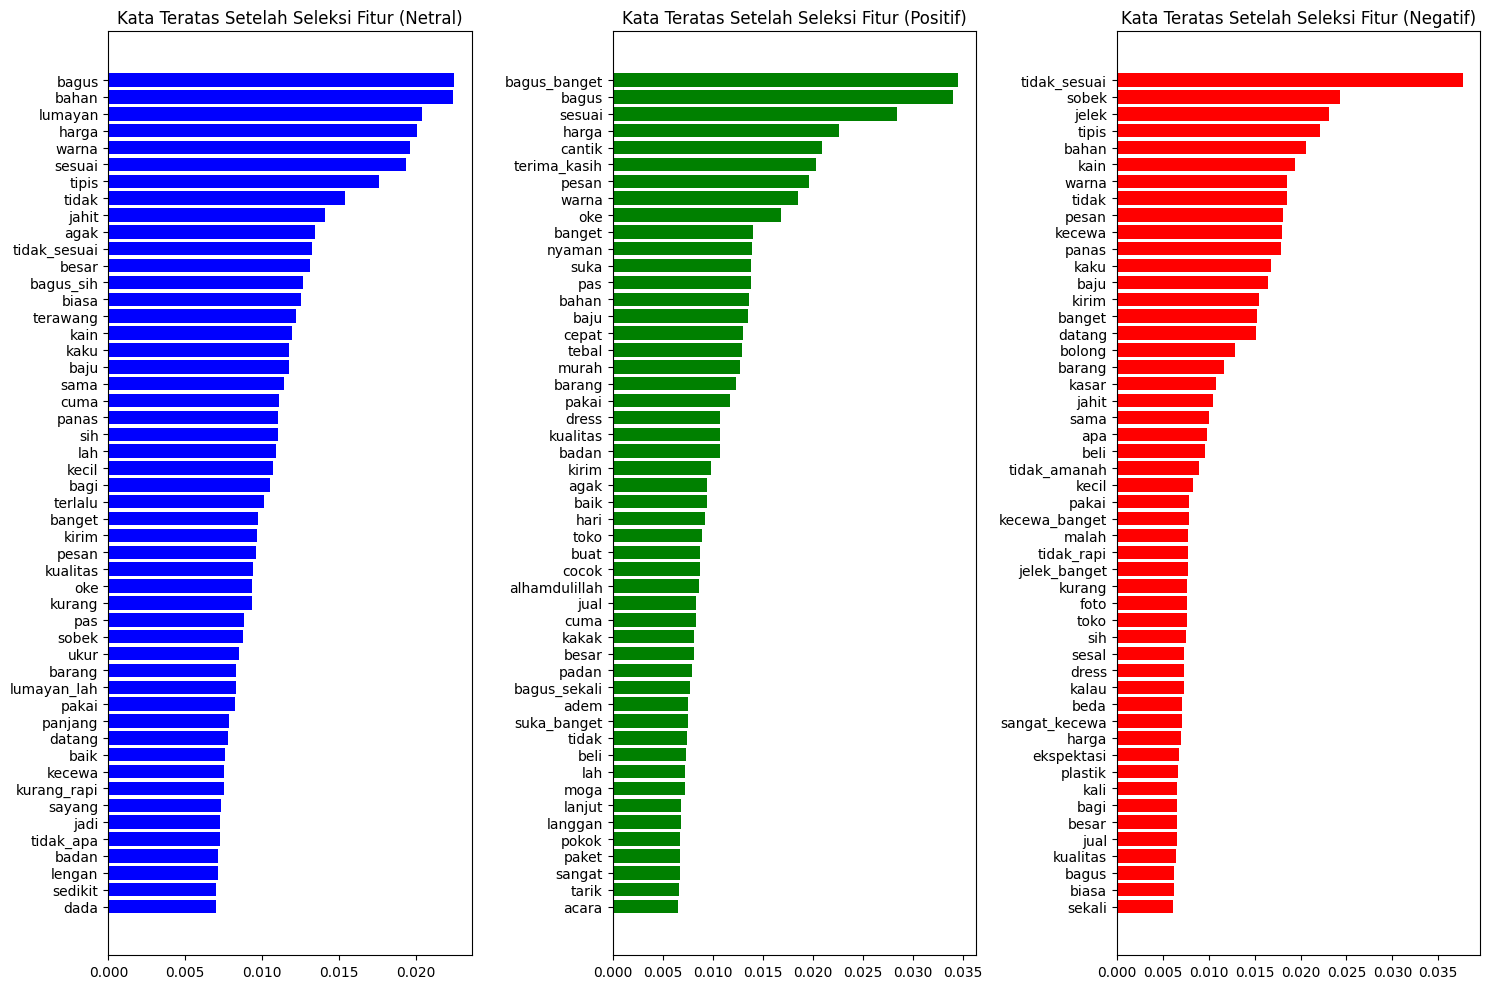

In [12]:
# Tambahkan kolom label sentimen ke dataframe hasil seleksi fitur
X_selected_labeled = X_selected.copy()
X_selected_labeled['Label Sentimen'] = data['Label Sentimen'].values

# Pisahkan TF-IDF berdasarkan kelas setelah seleksi fitur
tfidf_negatif_sel = X_selected_labeled[X_selected_labeled['Label Sentimen'] == -1].drop(columns='Label Sentimen')
tfidf_netral_sel = X_selected_labeled[X_selected_labeled['Label Sentimen'] == 0].drop(columns='Label Sentimen')
tfidf_positif_sel = X_selected_labeled[X_selected_labeled['Label Sentimen'] == 1].drop(columns='Label Sentimen')

# Hitung rata-rata skor TF-IDF tiap kata per kelas setelah seleksi fitur
avg_tfidf_negatif_sel = tfidf_negatif_sel.mean().sort_values(ascending=False).head(50)
avg_tfidf_netral_sel = tfidf_netral_sel.mean().sort_values(ascending=False).head(50)
avg_tfidf_positif_sel = tfidf_positif_sel.mean().sort_values(ascending=False).head(50)

# Plot grafik distribusi kata per kelas setelah seleksi fitur
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

# Netral
axes[0].barh(avg_tfidf_netral_sel.index[::-1], avg_tfidf_netral_sel.values[::-1], color='blue')
axes[0].set_title("Kata Teratas Setelah Seleksi Fitur (Netral)")

# Positif
axes[1].barh(avg_tfidf_positif_sel.index[::-1], avg_tfidf_positif_sel.values[::-1], color='green')
axes[1].set_title("Kata Teratas Setelah Seleksi Fitur (Positif)")

# Negatif
axes[2].barh(avg_tfidf_negatif_sel.index[::-1], avg_tfidf_negatif_sel.values[::-1], color='red')
axes[2].set_title("Kata Teratas Setelah Seleksi Fitur (Negatif)")

plt.tight_layout()
plt.show()


Memisahkan Fitur dan Label

In [13]:
X = X_selected  # Fitur: nilai TF-IDF untuk setiap dokumen
y = data['Label Sentimen']  # Label sentimen dari data

Multinomial Naive Bayes

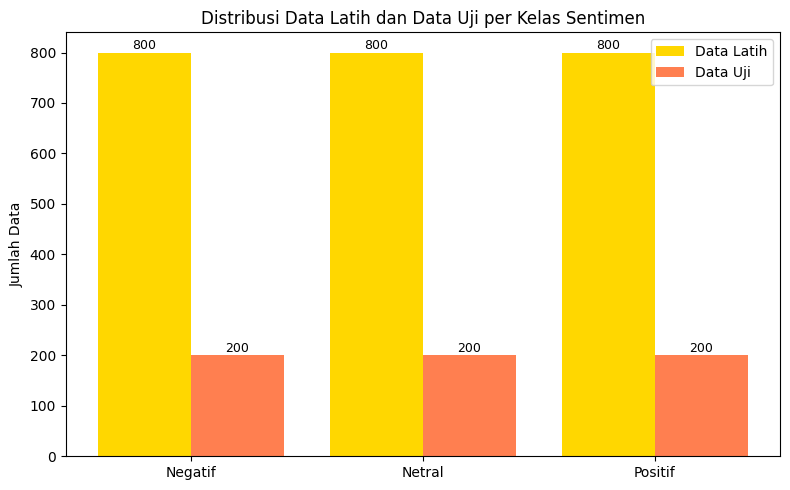

In [14]:
# Membagi dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Menghitung distribusi kelas pada data latih dan data uji
train_dist = y_train.value_counts().sort_index()
test_dist = y_test.value_counts().sort_index()

# Membuat diagram batang berdampingan
labels = ['Negatif', 'Netral', 'Positif']
x = range(len(labels))

# Menampilkan nilai jumlah data tepat di atas batangnya
plt.figure(figsize=(8,5))
bar1 = plt.bar([i - 0.2 for i in x], train_dist.values, width=0.4, label='Data Latih', color='gold')
bar2 = plt.bar([i + 0.2 for i in x], test_dist.values, width=0.4, label='Data Uji', color='coral')

# Menambahkan label dan judul
plt.xticks(x, labels)
plt.ylabel('Jumlah Data')
plt.title('Distribusi Data Latih dan Data Uji per Kelas Sentimen')
plt.legend()

# Menambahkan angka jumlah data di atas setiap batang
for bar in bar1 + bar2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(int(height)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



In [15]:
def train_multinomial_nb(X, y):
    """Melatih Multinomial Naive Bayes secara manual."""
    classes = np.unique(y)
    class_prior = {}
    word_prob = {}
    vocab = X.columns  # Kata unik setelah TF-IDF

    for c in classes:
        X_c = X[y.values == c]
        class_prior[c] = len(X_c) / len(y)  # Probabilitas prior
        
        # Menghitung probabilitas kata unik dalam kelas dengan Laplace smoothing
        word_counts = X_c.sum(axis=0) + 1  # Add-1 Laplace smoothing
        word_prob[c] = word_counts / (word_counts.sum() + len(vocab))  

    return {
        'class_prior': class_prior,
        'word_prob': word_prob,
        'vocab': vocab
    }

def predict_multinomial_nb(X_test, model):
    """Memprediksi kelas dari data uji."""
    class_prior = model['class_prior']
    word_prob = model['word_prob']
    vocab = model['vocab']

    predictions = []
    for _, doc in X_test.iterrows():
        class_scores = {}
        for c in class_prior.keys():
            prob = class_prior[c] * np.prod(np.power(word_prob[c][vocab], doc[vocab]))
            class_scores[c] = prob
        predictions.append(max(class_scores, key=class_scores.get))

    return np.array(predictions)

# Melatih model dengan data latih
model = train_multinomial_nb(X_train, y_train)

# Menampilkan hasil probabilitas prior kelas
print("=== Probabilitas Prior Setiap Kelas ===")
for c, prob in model['class_prior'].items():
    print(f"P({c}) = {prob}")

# Menampilkan probabilitas kata unik dalam setiap kelas
for c, probs in model['word_prob'].items():
    print(f"\n=== Probabilitas Kata Unik untuk Kelas {c} ===")
    print(probs.head(10))  # Menampilkan 10 kata pertama untuk ringkasan


=== Probabilitas Prior Setiap Kelas ===
P(-1) = 0.3333333333333333
P(0) = 0.3333333333333333
P(1) = 0.3333333333333333

=== Probabilitas Kata Unik untuk Kelas -1 ===
bagus_banget   0.000796
terima_kasih   0.000679
bagus          0.003100
tidak_sesuai   0.015322
cantik         0.000876
sesuai         0.002829
harga          0.003405
cepat          0.001070
suka           0.000615
kecewa         0.007567
dtype: float64

=== Probabilitas Kata Unik untuk Kelas 0 ===
bagus_banget   0.000739
terima_kasih   0.002542
bagus          0.009271
tidak_sesuai   0.005956
cantik         0.001570
sesuai         0.007999
harga          0.008400
cepat          0.002108
suka           0.002590
kecewa         0.003599
dtype: float64

=== Probabilitas Kata Unik untuk Kelas 1 ===
bagus_banget   0.014284
terima_kasih   0.009259
bagus          0.013722
tidak_sesuai   0.000732
cantik         0.008979
sesuai         0.012391
harga          0.009771
cepat          0.005764
suka           0.006356
kecewa         0

In [16]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

accuracies, precisions, recalls, f1_scores = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Melatih model pada fold ini
    model_fold = train_multinomial_nb(X_fold_train, y_fold_train)

    # Memprediksi kelas pada data validasi
    y_pred = predict_multinomial_nb(X_fold_val, model_fold)

    # Menghitung metrik evaluasi
    acc = accuracy_score(y_fold_val, y_pred)
    prec = precision_score(y_fold_val, y_pred, average='macro')
    rec = recall_score(y_fold_val, y_pred, average='macro')
    f1 = f1_score(y_fold_val, y_pred, average='macro')

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)

    print(f"Fold {fold+1}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1-Score={f1:.4f}")

# Menampilkan rata-rata hasil dari seluruh fold
print("\n=== Rata-rata Hasil Cross-Validation ===")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1-Score: {np.mean(f1_scores):.4f}")


Fold 1: Accuracy=0.6625, Precision=0.6677, Recall=0.6662, F1-Score=0.6666
Fold 2: Accuracy=0.7792, Precision=0.7748, Recall=0.7766, F1-Score=0.7753
Fold 3: Accuracy=0.7458, Precision=0.7458, Recall=0.7581, F1-Score=0.7483
Fold 4: Accuracy=0.7000, Precision=0.7046, Recall=0.7069, F1-Score=0.7023
Fold 5: Accuracy=0.7417, Precision=0.7571, Recall=0.7476, F1-Score=0.7486
Fold 6: Accuracy=0.7333, Precision=0.7216, Recall=0.7208, F1-Score=0.7211
Fold 7: Accuracy=0.7208, Precision=0.7245, Recall=0.7163, F1-Score=0.7190
Fold 8: Accuracy=0.7917, Precision=0.7899, Recall=0.7943, F1-Score=0.7909
Fold 9: Accuracy=0.7250, Precision=0.7326, Recall=0.7232, F1-Score=0.7244
Fold 10: Accuracy=0.7375, Precision=0.7396, Recall=0.7362, F1-Score=0.7359

=== Rata-rata Hasil Cross-Validation ===
Accuracy: 0.7337
Precision: 0.7358
Recall: 0.7346
F1-Score: 0.7332


Evaluasi pada Data Uji 
- data uji belum pernah dilihat model sebelumnya

In [17]:
# Melatih model dengan seluruh data latih
final_model = train_multinomial_nb(X_train, y_train)

# Melakukan prediksi pada data uji
y_pred_test = predict_multinomial_nb(X_test, final_model)


Confusssion Matrix pada Data Latih

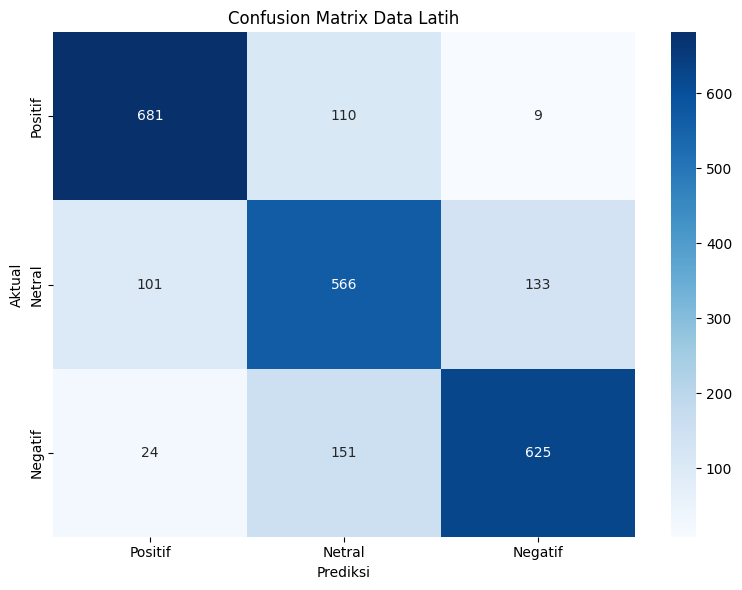

In [18]:
# Melakukan prediksi pada data latih
y_pred_train = predict_multinomial_nb(X_train, final_model)

# Membuat Confusion Matrix
cm_train = confusion_matrix(y_train, y_pred_train, labels=[1, 0, -1])
labels = ['Positif', 'Netral', 'Negatif']

# Visualisasi Confusion Matrix Data Latih
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Data Latih')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()


In [19]:
# Confusion Matrix:
conf_matrix = np.array([[679, 113, 8],
                        [103, 563, 134],
                        [24, 152, 624]])

# Mendefinisikan label aktual dan prediksi berdasarkan confusion matrix
y_true = []
y_pred = []

for actual_class in range(3):
    for predicted_class in range(3):
        count = conf_matrix[actual_class][predicted_class]
        y_true += [actual_class] * count
        y_pred += [predicted_class] * count

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
report = classification_report(y_true, y_pred, target_names=['Positif', 'Netral', 'Negatif'])

print("=== Hasil Evaluasi Akhir pada Data Training ===")
print(f"Akurasi  : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print("\n=== Classification Report ===")
print(report)


=== Hasil Evaluasi Akhir pada Data Training ===
Akurasi  : 0.7775
Precision: 0.7790
Recall   : 0.7775
F1-Score : 0.7781

=== Classification Report ===
              precision    recall  f1-score   support

     Positif       0.84      0.85      0.85       800
      Netral       0.68      0.70      0.69       800
     Negatif       0.81      0.78      0.80       800

    accuracy                           0.78      2400
   macro avg       0.78      0.78      0.78      2400
weighted avg       0.78      0.78      0.78      2400



Confussion Matriks pada Data Uji

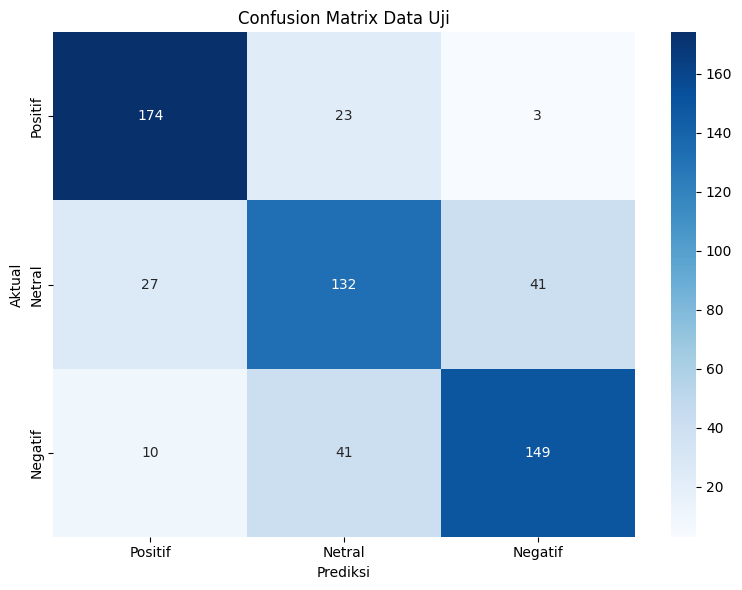

In [20]:
# Membuat Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test, labels=[1, 0, -1])
labels = ['Positif', 'Netral', 'Negatif']

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Data Uji')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.tight_layout()
plt.show()


In [21]:
# Data dari confusion matrix
# Baris = aktual, Kolom = prediksi
conf_matrix = np.array([[174, 23, 3],
                        [27, 131, 42],
                        [11, 39, 150]])

# Total jumlah data
total_samples = conf_matrix.sum()

# Menghitung nilai aktual dan prediksi
y_actual = []
y_pred = []

for actual_class in range(conf_matrix.shape[0]):
    for predicted_class in range(conf_matrix.shape[1]):
        count = conf_matrix[actual_class, predicted_class]
        y_actual.extend([actual_class] * count)
        y_pred.extend([predicted_class] * count)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_actual, y_pred)
precision = precision_score(y_actual, y_pred, average='macro')
recall = recall_score(y_actual, y_pred, average='macro')
f1 = f1_score(y_actual, y_pred, average='macro')
report = classification_report(y_actual, y_pred, target_names=["Positif", "Netral", "Negatif"])

print("=== Hasil Evaluasi Akhir pada Data Testing ===")
print(f"Akurasi  : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print("\n=== Classification Report ===")
print(report)



=== Hasil Evaluasi Akhir pada Data Testing ===
Akurasi  : 0.7583
Precision: 0.7562
Recall   : 0.7583
F1-Score : 0.7569

=== Classification Report ===
              precision    recall  f1-score   support

     Positif       0.82      0.87      0.84       200
      Netral       0.68      0.66      0.67       200
     Negatif       0.77      0.75      0.76       200

    accuracy                           0.76       600
   macro avg       0.76      0.76      0.76       600
weighted avg       0.76      0.76      0.76       600

